In [2]:
from pathlib import Path
import pandas as pd

# Kaggle'da eklediğin dataset yolu
INPUT = Path("/kaggle/input/skin-cancer-mnist-ham10000")

# 1) Metadata oku ve ilk satırları göster
meta_path = INPUT / "HAM10000_metadata.csv"
df = pd.read_csv(meta_path)
print("Metadata yolu:", meta_path)
print("Satır x Sütun:", df.shape)
display(df.head())

# 2) Görsel klasörleri var mı kontrol et (isim varyantlarını da dene)
candidates = [
    INPUT/"ham10000_images_part_1",
    INPUT/"ham10000_images_part_2",
    INPUT/"HAM10000_images_part_1",
    INPUT/"HAM10000_images_part_2",
    INPUT/"ham10000_images",
    INPUT/"HAM10000_images",
]
print("\nGörsel klasörleri:")
for p in candidates:
    print(p, "->", p.exists())

# 3) Örnek bir görsel yolu oluştur (sadece kontrol)
sample_file = df.loc[0, "image_id"] + ".jpg"
found = None
for p in candidates:
    if p.exists() and (p / sample_file).exists():
        found = p / sample_file
        break
print("\nÖrnek görsel (varsa):", found)


Metadata yolu: /kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv
Satır x Sütun: (10015, 7)


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear



Görsel klasörleri:
/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_1 -> True
/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_2 -> True
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1 -> True
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2 -> True
/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images -> False
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images -> False

Örnek görsel (varsa): /kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0027419.jpg


In [3]:
import pandas as pd, shutil
from pathlib import Path
from sklearn.model_selection import train_test_split

# Yollar
INPUT = Path("/kaggle/input/skin-cancer-mnist-ham10000")
PREP  = Path("/kaggle/working/data/prepared")
PREP.mkdir(parents=True, exist_ok=True)

df = pd.read_csv(INPUT/"HAM10000_metadata.csv")
df["filename"] = df["image_id"] + ".jpg"

# Split (%70 train, %15 val, %15 test)
train_df, temp = train_test_split(df, test_size=0.3, stratify=df["dx"], random_state=42)
val_df, test_df = train_test_split(temp, test_size=0.5, stratify=temp["dx"], random_state=42)

df["split"] = "train"
df.loc[val_df.index,"split"]  = "val"
df.loc[test_df.index,"split"] = "test"

# metadata.csv kaydet
df.to_csv(PREP/"metadata.csv", index=False)

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))

# Klasörleri oluştur
for split in ["train", "val", "test"]:
    for label in df["dx"].unique():
        (PREP/split/label).mkdir(parents=True, exist_ok=True)

# Resimleri kopyala
img_dirs = [
    INPUT/"ham10000_images_part_1",
    INPUT/"ham10000_images_part_2",
]

missing = 0
for _, row in df.iterrows():
    src = None
    for d in img_dirs:
        p = d/row["filename"]
        if p.exists():
            src = p
            break
    if src is None:
        missing += 1
        continue
    dst = PREP/row["split"]/row["dx"]/row["filename"]
    if not dst.exists():
        shutil.copy2(src, dst)

print("Kopyalama tamam ✅ Eksik:", missing)


Train: 7010 Val: 1502 Test: 1503
Kopyalama tamam ✅ Eksik: 0


In [4]:
import tensorflow as tf
import pandas as pd
from pathlib import Path

PREP = Path("/kaggle/working/data/prepared")
meta = pd.read_csv(PREP/"metadata.csv")

IMG_SIZE = (224,224)
AUTOTUNE = tf.data.AUTOTUNE

# Basit text özelliği (örnek: "sex:male localization:back age:45")
def build_text_feature(row):
    return f"sex:{row['sex']} localization:{row['localization']} age:{int(row['age']) if not pd.isna(row['age']) else -1}"

meta["text"] = meta.apply(build_text_feature, axis=1)
meta["filepath"] = meta.apply(lambda r: str(PREP/r["split"]/r["dx"]/r["filename"]), axis=1)

# Sınıf isimleri
class_names = sorted(meta["dx"].unique())
class_to_idx = {c:i for i,c in enumerate(class_names)}
num_classes = len(class_names)

meta["label"] = meta["dx"].map(class_to_idx)

print("Sınıflar:", class_names)

# TensorFlow dataset hazırlama
def decode_img(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    return tf.cast(img, tf.float32)/255.0

def make_ds(df, training=True, batch_size=32):
    paths = tf.convert_to_tensor(df["filepath"].values)
    texts = tf.convert_to_tensor(df["text"].values)
    labels = tf.one_hot(df["label"].values, num_classes)

    ds = tf.data.Dataset.from_tensor_slices((paths, texts, labels))

    def _map(path, text, label):
        img = decode_img(path)
        if training:
            img = tf.image.random_flip_left_right(img)
        return ({"image": img, "text": text}, label)

    if training:
        ds = ds.shuffle(2048)
    return ds.map(_map, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)

train_ds = make_ds(meta[meta["split"]=="train"])
val_ds   = make_ds(meta[meta["split"]=="val"], training=False)
test_ds  = make_ds(meta[meta["split"]=="test"], training=False)

print("Datasetler hazır ✅")


Sınıflar: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Datasetler hazır ✅


I0000 00:00:1757755830.528622      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757755830.529405      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [5]:
import tensorflow as tf

def build_fusion_model(num_classes, vocab_size=4000, seq_len=24, embed_dim=64):
    # 🔹 Görsel taraf
    img_in = tf.keras.Input(shape=(224,224,3), name="image")
    x = tf.keras.applications.mobilenet_v2.preprocess_input(img_in*255.0)
    base = tf.keras.applications.MobileNetV2(
        include_top=False, weights="imagenet", input_shape=(224,224,3))
    base.trainable = False  # önce dondur
    x = base(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    # 🔹 Text taraf
    txt_in = tf.keras.Input(shape=(), dtype=tf.string, name="text")
    vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=vocab_size, output_mode="int", output_sequence_length=seq_len
    )
    # Adapt etmeyi unutma (train text ile yapacağız)
    t = vectorizer(txt_in)
    t = tf.keras.layers.Embedding(vocab_size, embed_dim, mask_zero=True)(t)
    t = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64))(t)
    t = tf.keras.layers.Dropout(0.2)(t)

    # 🔹 Füzyon
    z = tf.keras.layers.Concatenate()([x, t])
    z = tf.keras.layers.Dense(256, activation="relu")(z)
    z = tf.keras.layers.Dropout(0.3)(z)
    out = tf.keras.layers.Dense(num_classes, activation="softmax")(z)

    model = tf.keras.Model(inputs=[img_in, txt_in], outputs=out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model, vectorizer

# Model oluştur
model, text_vec = build_fusion_model(num_classes=len(class_names))
print(model.summary())

# TextVectorization adapt → train text ile
train_texts = meta[meta["split"]=="train"]["text"].astype(str).tolist()
text_vec.adapt(tf.data.Dataset.from_tensor_slices(train_texts).batch(256))
print("Text vectorizer adapte edildi ✅")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 224, 224,  │          0 │ image[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide         │ (None, 224, 224,  │          0 │ multiply[0][0]    │
│ (TrueDivide)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text (InputLayer)   │ (None)            │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract (Subtract) │ (None, 224, 224,  │          0 │ true_divide[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 24)        │          0 │ text[0][0]        │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 7, 7,      │  2,257,984 │ subtract[0][0]    │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 24, 64)    │    256,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 24)        │          0 │ text_vectorizati… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │     49,920 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1280)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1408)      │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    360,704 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 7)         │      1,799 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,926,407 (11.16 MB)

 Trainable params: 668,423 (2.55 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

None
Text vectorizer adapte edildi ✅


In [6]:
# Class imbalance için ağırlık hesapla
from collections import Counter

cnt = Counter(meta[meta["split"]=="train"]["dx"])
total = sum(cnt.values())
class_weight = {class_to_idx[c]: total/(len(class_names)*cnt[c]) for c in class_names}
print("Class weights:", class_weight)

# Callback'ler
ckpt = tf.keras.callbacks.ModelCheckpoint(
    "/kaggle/working/best_model.keras", monitor="val_accuracy", save_best_only=True, verbose=1
)
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=3, restore_best_weights=True
)

# Eğitim
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weight,
    callbacks=[ckpt, es]
)

# Test sonucu
print("Test sonucu:", model.evaluate(test_ds, verbose=0))


Class weights: {0: 4.37305053025577, 1: 2.7817460317460316, 2: 1.3022478172023035, 3: 12.36331569664903, 4: 1.285530900421786, 5: 0.21338772031292808, 6: 10.115440115440116}
Epoch 1/10


I0000 00:00:1757755844.656782     102 cuda_dnn.cc:529] Loaded cuDNN version 90300


220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.4280 - loss: 2.2517
Epoch 1: val_accuracy improved from -inf to 0.57457, saving model to /kaggle/working/best_model.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 37s 104ms/step - accuracy: 0.4285 - loss: 2.2479 - val_accuracy: 0.5746 - val_loss: 1.2758
Epoch 2/10
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5091 - loss: 1.6699
Epoch 2: val_accuracy improved from 0.57457 to 0.61718, saving model to /kaggle/working/best_model.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - accuracy: 0.5101 - loss: 1.6644 - val_accuracy: 0.6172 - val_loss: 1.1733
Epoch 3/10
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5663 - loss: 1.3439
Epoch 3: val_accuracy improved from 0.61718 to 0.66378, saving model to /kaggle/working/best_model.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - accuracy: 0.5672 - loss: 1.3401 - val_accuracy: 0.6638 - val_loss: 0.9132
Epoch 4/10
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6109 - loss: 

In [7]:
# ✅ Class imbalance için ağırlıklar
from collections import Counter
cnt = Counter(meta[meta["split"]=="train"]["dx"])
total = sum(cnt.values())
class_weight = {class_to_idx[c]: total/(len(class_names)*cnt[c]) for c in class_names}
print("Class weights:", class_weight)

# ✅ Data augmentation (görseller için)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

# Dataset pipeline’ını augmentation ile güncelle
def make_ds(df, training=True, batch_size=32):
    paths = tf.convert_to_tensor(df["filepath"].values)
    texts = tf.convert_to_tensor(df["text"].values)
    labels = tf.one_hot(df["label"].values, num_classes)

    ds = tf.data.Dataset.from_tensor_slices((paths, texts, labels))

    def _map(path, text, label):
        img = tf.io.read_file(path)
        img = tf.io.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.cast(img, tf.float32)/255.0
        if training:
            img = data_augmentation(img)
        return ({"image": img, "text": text}, label)

    if training:
        ds = ds.shuffle(2048)
    return ds.map(_map, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)

train_ds = make_ds(meta[meta["split"]=="train"])
val_ds   = make_ds(meta[meta["split"]=="val"], training=False)
test_ds  = make_ds(meta[meta["split"]=="test"], training=False)

# ✅ Callback'ler
ckpt = tf.keras.callbacks.ModelCheckpoint(
    "/kaggle/working/best_model.keras", monitor="val_auc", mode="max",
    save_best_only=True, verbose=1
)
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_auc", mode="max",
    patience=5, restore_best_weights=True
)
lr_sched = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_auc", mode="max",
    factor=0.5, patience=2, verbose=1, min_lr=1e-7
)

# ✅ Eğitim
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,   # daha uzun tut, early stopping ile durur
    class_weight=class_weight,
    callbacks=[ckpt, es, lr_sched]
)

# ✅ Test sonucu
print("Test sonucu:", model.evaluate(test_ds, verbose=0))


Class weights: {0: 4.37305053025577, 1: 2.7817460317460316, 2: 1.3022478172023035, 3: 12.36331569664903, 4: 1.285530900421786, 5: 0.21338772031292808, 6: 10.115440115440116}
Epoch 1/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 60s 270ms/step - accuracy: 0.5707 - loss: 1.3430 - val_accuracy: 0.6391 - val_loss: 1.0829 - learning_rate: 0.0010
Epoch 2/30


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_auc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_auc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


220/220 ━━━━━━━━━━━━━━━━━━━━ 59s 269ms/step - accuracy: 0.5559 - loss: 1.3388 - val_accuracy: 0.6105 - val_loss: 1.1251 - learning_rate: 0.0010
Epoch 3/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 60s 270ms/step - accuracy: 0.5593 - loss: 1.3715 - val_accuracy: 0.6338 - val_loss: 1.0242 - learning_rate: 0.0010
Epoch 4/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 59s 269ms/step - accuracy: 0.6201 - loss: 1.1526 - val_accuracy: 0.6245 - val_loss: 1.0302 - learning_rate: 0.0010
Epoch 5/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 59s 269ms/step - accuracy: 0.6055 - loss: 1.1969 - val_accuracy: 0.6658 - val_loss: 0.8737 - learning_rate: 0.0010
Epoch 6/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 59s 270ms/step - accuracy: 0.6169 - loss: 1.2000 - val_accuracy: 0.6731 - val_loss: 0.8977 - learning_rate: 0.0010
Epoch 7/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 59s 270ms/step - accuracy: 0.6077 - loss: 1.1979 - val_accuracy: 0.6671 - val_loss: 0.9081 - learning_rate: 0.0010
Epoch 8/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 60s 270ms/step - accuracy: 0.6331 - loss:

In [8]:
# ✅ Mevcut modeli kaydet
model.save("/kaggle/working/ham10000_model_v1.keras")

print("Mevcut model kaydedildi ✅ /kaggle/working/ham10000_model_v1.keras")

Mevcut model kaydedildi ✅ /kaggle/working/ham10000_model_v1.keras


In [9]:
# 🚀 Yeni deneme: val_auc metrikli
from tensorflow import keras

# Tekrar compile (AUC dahil)
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc")]
)

# Class weights hesaplamıştık zaten -> class_weight değişkenini kullan
# Yeni callback'ler
ckpt = keras.callbacks.ModelCheckpoint(
    "/kaggle/working/best_model_auc.keras",
    monitor="val_auc", save_best_only=True, mode="max", verbose=1
)
es = keras.callbacks.EarlyStopping(
    monitor="val_auc", patience=5, restore_best_weights=True, mode="max"
)
rlr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_auc", factor=0.5, patience=2, verbose=1, mode="max"
)

# Eğitim
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,   # uzun eğitim için daha fazla epoch
    class_weight=class_weight,
    callbacks=[ckpt, es, rlr]
)

# Test sonucu
print("Test sonucu:", model.evaluate(test_ds, verbose=0))

Epoch 1/50
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.7211 - auc: 0.9545 - loss: 0.8487
Epoch 1: val_auc improved from -inf to 0.95503, saving model to /kaggle/working/best_model_auc.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 73s 279ms/step - accuracy: 0.7215 - auc: 0.9546 - loss: 0.8463 - val_accuracy: 0.7364 - val_auc: 0.9550 - val_loss: 0.7418 - learning_rate: 0.0010
Epoch 2/50
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.7284 - auc: 0.9569 - loss: 0.7640
Epoch 2: val_auc did not improve from 0.95503
220/220 ━━━━━━━━━━━━━━━━━━━━ 59s 270ms/step - accuracy: 0.7287 - auc: 0.9569 - loss: 0.7620 - val_accuracy: 0.7130 - val_auc: 0.9454 - val_loss: 0.8360 - learning_rate: 0.0010
Epoch 3/50
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.7114 - auc: 0.9525 - loss: 0.7936
Epoch 3: val_auc did not improve from 0.95503

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
220/220 ━━━━━━━━━━━━━━━━━━━━ 60s 272ms/step - accuracy: 0.7118 - auc: 0.

In [10]:
from tensorflow import keras

# En iyi modeli yükle
model = keras.models.load_model("/kaggle/working/best_model_auc.keras")

print("✅ best_model_auc.keras yüklendi")


✅ best_model_auc.keras yüklendi


In [11]:
import tensorflow as tf
import pandas as pd
from pathlib import Path
from collections import Counter

# ================== DATA ==================
PREP = Path("/kaggle/working/data/prepared")
meta = pd.read_csv(PREP/"metadata.csv")

IMG_SIZE = (256,256)
AUTOTUNE = tf.data.AUTOTUNE

# class mapping
class_names = sorted(meta["dx"].unique())
class_to_idx = {c:i for i,c in enumerate(class_names)}
num_classes = len(class_names)
meta["label"] = meta["dx"].map(class_to_idx)

# text feature
def build_text_feature(row):
    return f"sex:{row['sex']} localization:{row['localization']} age:{int(row['age']) if not pd.isna(row['age']) else -1}"
meta["text"] = meta.apply(build_text_feature, axis=1)
meta["filepath"] = meta.apply(lambda r: str(PREP/r["split"]/r["dx"]/r["filename"]), axis=1)

# augmentation
data_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.05,0.05),
    tf.keras.layers.RandomContrast(0.1),
])

def decode_img(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    return tf.cast(img, tf.float32)/255.0

def make_ds(df, training=True, batch_size=32):
    paths = tf.convert_to_tensor(df["filepath"].values)
    texts = tf.convert_to_tensor(df["text"].values)
    labels = tf.one_hot(df["label"].values, num_classes)

    ds = tf.data.Dataset.from_tensor_slices((paths, texts, labels))
    def _map(path, text, label):
        img = decode_img(path)
        if training:
            img = data_aug(img)
        return ({"image": img, "text": text}, label)

    if training: ds = ds.shuffle(2048)
    return ds.map(_map, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)

train_ds = make_ds(meta[meta["split"]=="train"])
val_ds   = make_ds(meta[meta["split"]=="val"], training=False)
test_ds  = make_ds(meta[meta["split"]=="test"], training=False)

# ================== MODEL ==================
def build_fusion_model(num_classes, vocab_size=4000, seq_len=24, embed_dim=64):
    # image branch
    img_in = tf.keras.Input(shape=(IMG_SIZE[0],IMG_SIZE[1],3), name="image")
    x = tf.keras.applications.mobilenet_v2.preprocess_input(img_in*255.0)
    base = tf.keras.applications.MobileNetV2(include_top=False, weights="imagenet",
                                             input_shape=(IMG_SIZE[0],IMG_SIZE[1],3))
    base.trainable = True   # fine-tune
    for l in base.layers[:-30]:
        l.trainable = False

    x = base(x, training=True)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    # text branch
    txt_in = tf.keras.Input(shape=(), dtype=tf.string, name="text")
    vectorizer = tf.keras.layers.TextVectorization(max_tokens=vocab_size,
                                                   output_mode="int",
                                                   output_sequence_length=seq_len)
    vectorizer.adapt(tf.data.Dataset.from_tensor_slices(
        meta[meta["split"]=="train"]["text"].astype(str).tolist()
    ).batch(256))

    t = vectorizer(txt_in)
    t = tf.keras.layers.Embedding(vocab_size, embed_dim, mask_zero=True)(t)
    t = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64))(t)
    t = tf.keras.layers.Dropout(0.3)(t)

    # fusion
    z = tf.keras.layers.Concatenate()([x,t])
    z = tf.keras.layers.Dense(256, activation="relu")(z)
    z = tf.keras.layers.Dropout(0.4)(z)
    out = tf.keras.layers.Dense(num_classes, activation="softmax")(z)

    model = tf.keras.Model(inputs=[img_in, txt_in], outputs=out)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss=loss,
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
    )
    return model

model = build_fusion_model(num_classes)
print(model.summary())

# ================== CLASS WEIGHTS ==================
cnt = Counter(meta[meta["split"]=="train"]["dx"])
total = sum(cnt.values())
class_weight = {class_to_idx[c]: total/(len(class_names)*cnt[c]) for c in class_names}
print("Class weights:", class_weight)

# ================== CALLBACKS ==================
ckpt = tf.keras.callbacks.ModelCheckpoint(
    "/kaggle/working/best_model_auc.keras",
    monitor="val_auc", save_best_only=True, mode="max", verbose=1
)
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_auc", patience=5, restore_best_weights=True, mode="max"
)
rlr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_auc", factor=0.5, patience=2, verbose=1, mode="max"
)

# ================== TRAIN ==================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weight,
    callbacks=[ckpt, es, rlr]
)

# ================== TEST ==================
print("Test sonucu:", model.evaluate(test_ds, verbose=0))

# ================== SAVE FINAL ==================
model.save("/kaggle/working/ham10000_finetuned_v2.keras")
print("Final model kaydedildi ✅")


/tmp/ipykernel_36/3188788225.py:64: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = tf.keras.applications.MobileNetV2(include_top=False, weights="imagenet",


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 256, 256,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 256, 256,  │          0 │ image[0][0]       │
│ (Multiply)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide_1       │ (None, 256, 256,  │          0 │ multiply_1[0][0]  │
│ (TrueDivide)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text (InputLayer)   │ (None)            │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_1          │ (None, 256, 256,  │          0 │ true_divide_1[0]… │
│ (Subtract)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization… │ (None, 24)        │          0 │ text[0][0]        │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 8, 8,      │  2,257,984 │ subtract_1[0][0]  │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 24, 64)    │    256,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 24)        │          0 │ text_vectorizati… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128)       │     49,920 │ embedding_1[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 1280)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1408)      │          0 │ dropout_3[0][0],  │
│ (Concatenate)       │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    360,704 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 256)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 7)         │      1,799 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,926,407 (11.16 MB)

 Trainable params: 2,194,823 (8.37 MB)

 Non-trainable params: 731,584 (2.79 MB)

None
Class weights: {0: 4.37305053025577, 1: 2.7817460317460316, 2: 1.3022478172023035, 3: 12.36331569664903, 4: 1.285530900421786, 5: 0.21338772031292808, 6: 10.115440115440116}
Epoch 1/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.1616 - auc: 0.5350 - loss: 3.1018
Epoch 1: val_auc improved from -inf to 0.70743, saving model to /kaggle/working/best_model_auc.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 104s 384ms/step - accuracy: 0.1616 - auc: 0.5351 - loss: 3.0976 - val_accuracy: 0.2623 - val_auc: 0.7074 - val_loss: 1.7730 - learning_rate: 1.0000e-05
Epoch 2/30
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.1878 - auc: 0.5903 - loss: 2.8529
Epoch 2: val_auc improved from 0.70743 to 0.82031, saving model to /kaggle/working/best_model_auc.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 82s 373ms/step - accuracy: 0.1881 - auc: 0.5906 - loss: 2.8446 - val_accuracy: 0.4734 - val_auc: 0.8203 - val_loss: 1.5298 - learning_rate: 1.0000e-05
Epoch 3/30
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/st

In [12]:
from tensorflow import keras
import tensorflow as tf

# ✅ Kaydedilmiş en iyi modeli yükle
model = keras.models.load_model("/kaggle/working/best_model_auc.keras",
                                custom_objects={"auc": tf.keras.metrics.AUC(name="auc")})
print("Model yüklendi ✅")

# ✅ MobileNetV2 backbone’u bul
base = None
for layer in model.layers:
    if "mobilenetv2" in layer.name:
        base = layer
        break

if base is None:
    raise ValueError("MobileNetV2 backbone bulunamadı.")

# ✅ Fine-tuning için aç
base.trainable = True
print("Son katmanlar fine-tuning için açıldı ✅")

# ✅ Learning rate küçük olmalı (çok düşük!)
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc")]
)

# ✅ Callback’ler
ckpt = keras.callbacks.ModelCheckpoint(
    "/kaggle/working/best_model_finetuned.keras",
    monitor="val_auc", mode="max",
    save_best_only=True, verbose=1
)
es = keras.callbacks.EarlyStopping(
    monitor="val_auc", mode="max",
    patience=5, restore_best_weights=True
)
lr_sched = keras.callbacks.ReduceLROnPlateau(
    monitor="val_auc", mode="max",
    factor=0.5, patience=2, verbose=1, min_lr=1e-7
)

# ✅ Eğitim (fine-tuning)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,   # çok uzun olmasına gerek yok
    class_weight=class_weight,
    callbacks=[ckpt, es, lr_sched]
)

# ✅ Test sonucu
print("Fine-tuning sonrası test:", model.evaluate(test_ds, verbose=0))


Model yüklendi ✅
Son katmanlar fine-tuning için açıldı ✅
Epoch 1/15
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.6081 - auc: 0.9130 - loss: 1.0896
Epoch 1: val_auc improved from -inf to 0.95476, saving model to /kaggle/working/best_model_finetuned.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 103s 388ms/step - accuracy: 0.6080 - auc: 0.9129 - loss: 1.0870 - val_accuracy: 0.7250 - val_auc: 0.9548 - val_loss: 0.7632 - learning_rate: 1.0000e-05
Epoch 2/15
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.5926 - auc: 0.9061 - loss: 1.1265
Epoch 2: val_auc did not improve from 0.95476
220/220 ━━━━━━━━━━━━━━━━━━━━ 82s 373ms/step - accuracy: 0.5926 - auc: 0.9061 - loss: 1.1233 - val_accuracy: 0.7184 - val_auc: 0.9535 - val_loss: 0.7643 - learning_rate: 1.0000e-05
Epoch 3/15
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.5980 - auc: 0.9102 - loss: 1.0944
Epoch 3: val_auc did not improve from 0.95476

Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.


In [13]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# ✅ En iyi fine-tuned modeli yükle
model = keras.models.load_model("/kaggle/working/best_model_finetuned.keras")
print("Fine-tuned model yüklendi ✅")

# ✅ TTA fonksiyonu
def predict_tta(model, dataset, tta_rounds=5):
    """
    Test Time Augmentation ile tahmin yapar.
    dataset: (image, text) içeren tf.data.Dataset
    tta_rounds: kaç farklı augmentation uygulanacak
    """
    preds_all = []

    # Augmentation pipeline (sadece test için hafif augment)
    aug = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.05),
        tf.keras.layers.RandomContrast(0.1),
    ])

    for i in range(tta_rounds):
        print(f"TTA round {i+1}/{tta_rounds} ...")
        aug_ds = dataset.map(
            lambda x, y: ({"image": aug(x["image"]), "text": x["text"]}, y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        preds = model.predict(aug_ds, verbose=0)
        preds_all.append(preds)

    # Ortalama tahmin
    preds_mean = np.mean(preds_all, axis=0)
    return preds_mean

# ✅ TTA ile test tahmini
tta_preds = predict_tta(model, test_ds, tta_rounds=5)
tta_labels = np.argmax(tta_preds, axis=1)
true_labels = np.argmax(np.vstack([y for _, y in test_ds]), axis=1)

# ✅ TTA sonrası metrikler
from sklearn.metrics import classification_report, roc_auc_score

print("\nClassification Report (TTA):")
print(classification_report(true_labels, tta_labels, target_names=class_names))

auc_macro = roc_auc_score(
    tf.keras.utils.to_categorical(true_labels, num_classes=len(class_names)),
    tta_preds,
    average="macro"
)
print(f"\nTTA Macro AUC: {auc_macro:.4f}")


Fine-tuned model yüklendi ✅
TTA round 1/5 ...
TTA round 2/5 ...
TTA round 3/5 ...
TTA round 4/5 ...
TTA round 5/5 ...

Classification Report (TTA):
              precision    recall  f1-score   support

       akiec       0.29      0.80      0.43        49
         bcc       0.54      0.57      0.55        77
         bkl       0.48      0.48      0.48       165
          df       0.24      0.59      0.34        17
         mel       0.40      0.53      0.46       167
          nv       0.94      0.77      0.84      1006
        vasc       0.46      0.82      0.59        22

    accuracy                           0.70      1503
   macro avg       0.48      0.65      0.53      1503
weighted avg       0.77      0.70      0.72      1503


TTA Macro AUC: 0.9156


TTA round 1/5 ...
TTA round 2/5 ...
TTA round 3/5 ...
TTA round 4/5 ...
TTA round 5/5 ...


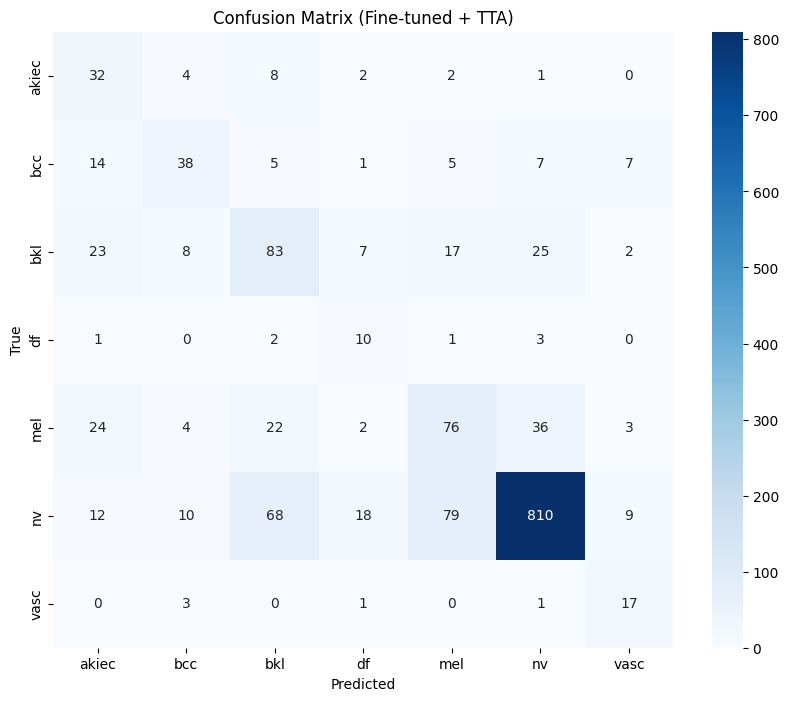


Classification Report (Fine-tuned + TTA):
              precision    recall  f1-score   support

       akiec       0.30      0.65      0.41        49
         bcc       0.57      0.49      0.53        77
         bkl       0.44      0.50      0.47       165
          df       0.24      0.59      0.34        17
         mel       0.42      0.46      0.44       167
          nv       0.92      0.81      0.86      1006
        vasc       0.45      0.77      0.57        22

    accuracy                           0.71      1503
   macro avg       0.48      0.61      0.52      1503
weighted avg       0.76      0.71      0.73      1503

Macro AUC: 0.9096094893395458


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# ✅ Test setindeki gerçek label’lar
y_true = []
for _, label in test_ds.unbatch():
    y_true.append(np.argmax(label.numpy()))
y_true = np.array(y_true)

# ✅ TTA ile tahmin yap (5 round)
tta_preds = []
for r in range(5):
    print(f"TTA round {r+1}/5 ...")
    preds = model.predict(test_ds, verbose=0)
    tta_preds.append(preds)

# Ortalama al → final prediction
y_pred_proba = np.mean(tta_preds, axis=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# ✅ Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Fine-tuned + TTA)")
plt.show()

# ✅ Classification Report (precision, recall, f1)
print("\nClassification Report (Fine-tuned + TTA):")
print(classification_report(y_true, y_pred, target_names=class_names))

# ✅ Macro AUC
macro_auc = roc_auc_score(y_true, y_pred_proba, multi_class="ovr", average="macro")
print("Macro AUC:", macro_auc)


In [31]:
import gradio as gr
import numpy as np
from PIL import Image

# En iyi modeli yükle
best_model = tf.keras.models.load_model("/kaggle/working/best_model.keras")

def predict_fn(img, text):
    if img is None or text.strip() == "":
        return "⚠️ Lütfen görsel ve kısa metadata giriniz."

    # Görseli hazırla
    img = Image.fromarray(img).convert("RGB").resize((224,224))
    x = np.expand_dims(np.array(img, dtype=np.float32)/255.0, 0)

    # Text'i tf.constant yap
    txt = tf.constant([text])

    # 🚀 Burada tuple veriyoruz (dict değil!)
    preds = best_model.predict(({"image": x, "text": txt},), verbose=0)[0]

    idx = int(np.argmax(preds))
    conf = float(np.max(preds))
    return f"Tahmin: {class_names[idx]} | Güven: {conf:.1%}"


# Arayüz
demo = gr.Interface(
    fn=predict_fn,
    inputs=[
        gr.Image(type="numpy", label="Lezyon Görseli"),
        gr.Textbox(lines=2, placeholder="örn: sex:male localization:back age:45", label="Metadata"),
    ],
    outputs="text",
    title="DermAI Demo",
    flagging_mode="never"   # güncel parametre
)

demo.launch(inline=True, share=True)



* Running on local URL:  http://127.0.0.1:7862
* Running on public URL: https://6da0134c6fdd44f53d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['image', 'text']
Received: inputs=({'image': 'Tensor(shape=(1, 224, 224, 3))', 'text': 'Tensor(shape=(1,))'},)
  warnings.warn(msg)
